# Load necessary libraries

In [1]:
import os
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from keras.models import load_model

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Read & Understand the Data

In [2]:
file_path = 'hypothetical_pump_failure_dataset.csv'

df = pd.read_csv(file_path)
df['timestamp'] = df.apply(lambda x : pd.to_datetime(x.timestamp), axis=1)
df = df.set_index('timestamp')
df.shape

(1000, 5)

In [3]:
df.head()

,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
timestamp,,,,,
2024-01-01 00:00:00,0.549671,76.996777,93.248217,40.460962,0
2024-01-01 01:00:00,0.486174,74.623168,98.554813,45.698075,0
2024-01-01 02:00:00,0.564769,70.298152,92.075801,47.931972,0
2024-01-01 03:00:00,0.652303,66.765316,96.920385,59.438438,0
2024-01-01 04:00:00,0.476585,73.491117,81.063853,52.782766,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2024-01-01 00:00:00 to 2024-02-11 15:00:00
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   vibration_level  1000 non-null   float64
 1   temperature_C    1000 non-null   float64
 2   pressure_PSI     1000 non-null   float64
 3   flow_rate_m3h    1000 non-null   float64
 4   failure          1000 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 46.9 KB


## Data Cleaning:

### Missing vaues

In [5]:
df.isnull().sum()

vibration_level    0
temperature_C      0
pressure_PSI       0
flow_rate_m3h      0
failure            0
dtype: int64

### Distribution

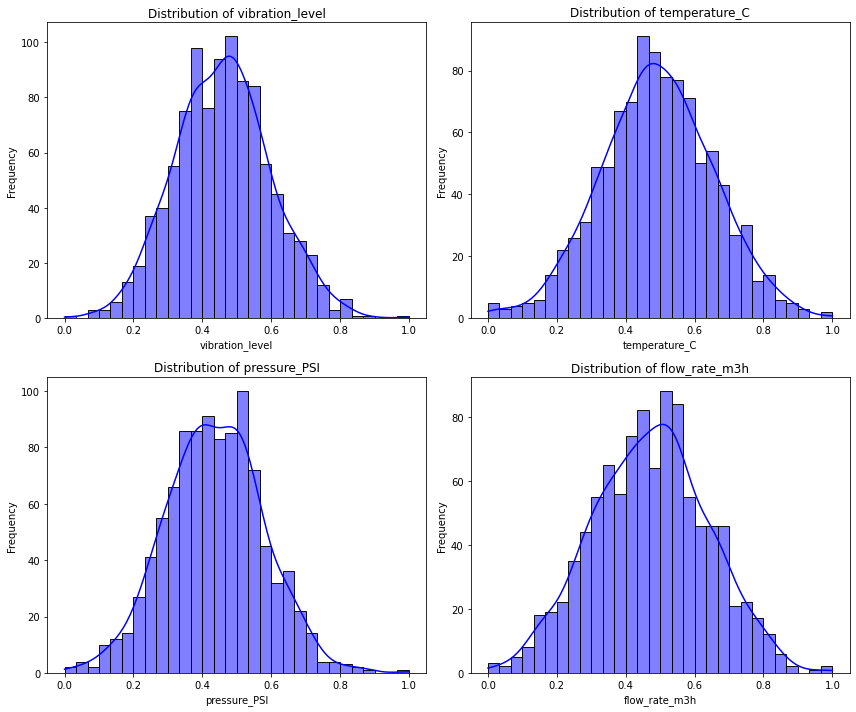

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

for i, feature in enumerate(FEATURES):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [57]:
skewness_values = df[['vibration_level', 'temperature_C', 'pressure_PSI', 'flow_rate_m3h']].skew()
print(skewness_values)

vibration_level    0.116976
temperature_C     -0.049396
pressure_PSI       0.061247
flow_rate_m3h     -0.002121
dtype: float64


Vibration Level: The distribution is centered around 0.5 with slight variation, suggesting most pumps experience low to moderate vibration levels, and no extreme outliers are immediately visible.

Temperature (°C): The temperature distribution appears roughly normal, centered around 70°C, with slight variations, suggesting most pumps operate within a narrow temperature range. slight left skewness is visible.

Pressure (PSI): The pressure distribution is also fairly normal, centered around 95 PSI, indicating that most pumps are operating within a standard pressure range, with few instances of extreme high or low pressure.

Flow Rate (m³/h): The flow rate shows a slightly skewed distribution, with most values concentrated between 40 and 60 m³/h. This may indicate that pumps typically operate within a consistent flow range.

# Visual Analysis

### Time Series Plots 

<AxesSubplot:xlabel='timestamp'>

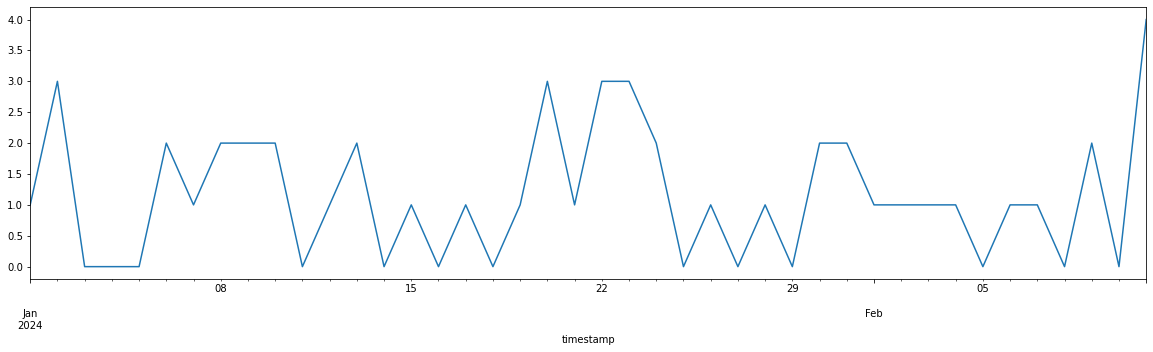

In [58]:
# visualize the count of failure in each day
df[df.failure==1].resample(rule='D')['failure'].count().plot(figsize=(20,5))

<AxesSubplot:xlabel='timestamp'>

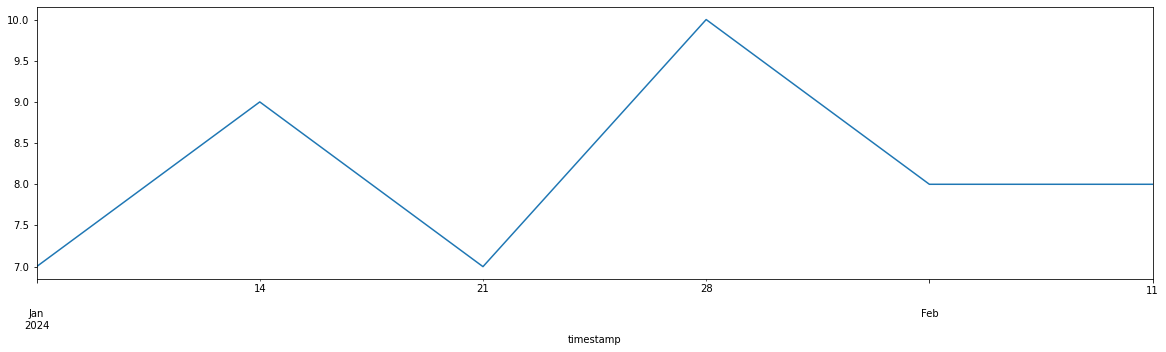

In [59]:
# visualize the count of failure in each week
df[df.failure==1].resample(rule='W')['failure'].count().plot(figsize=(20,5))

<AxesSubplot:xlabel='timestamp'>

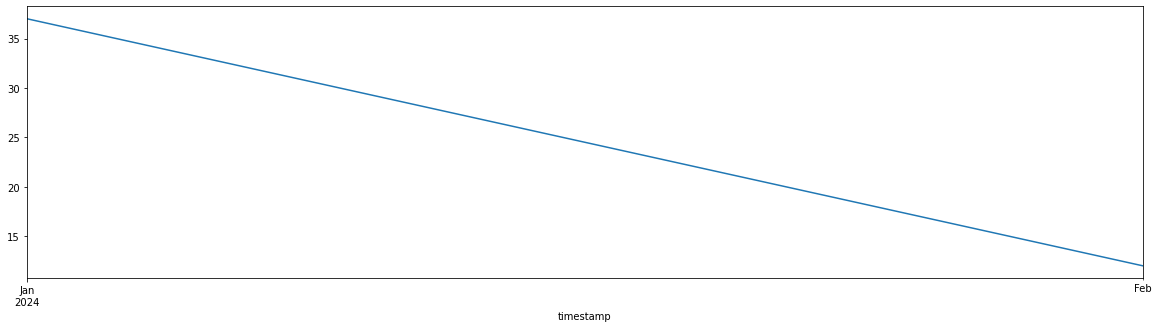

In [60]:
# visualize the count of failure in each month
df[df.failure==1].resample(rule='M')['failure'].count().plot(figsize=(20,5))

In [61]:
Rolling Average
Stationarity, prop ADF test, P value
convert non stat to stationary --> sqr root cb root

SyntaxError: invalid syntax (2172223735.py, line 1)

## Correlation Matrix:

<AxesSubplot:>

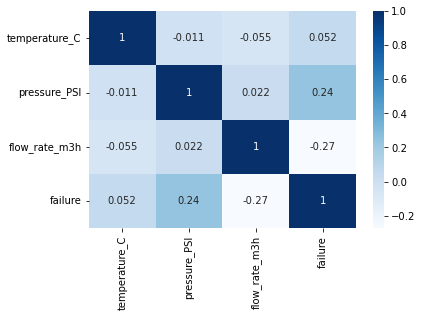

In [62]:
corr = df.iloc[:, 1:].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

pressure, flow rate Level and Failure: Shows a moderate positive correlation, indicating that higher pressure levels may lead to pump failure.

### Box plot analysis 

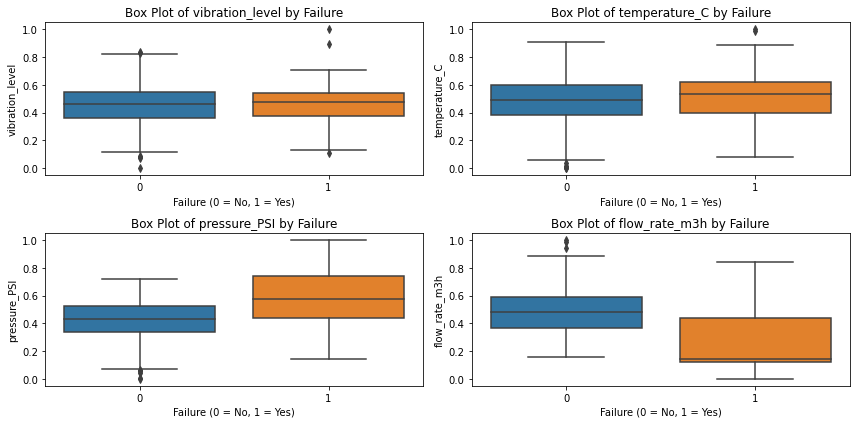

In [63]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

FEATURES = ['vibration_level', 'temperature_C', 'pressure_PSI', 'flow_rate_m3h']
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='failure', y=feature, data=df)
    plt.title(f'Box Plot of {feature} by Failure')
    plt.xlabel('Failure (0 = No, 1 = Yes)')
    plt.ylabel(feature)

# Show the plots
plt.tight_layout()
plt.show()

## Statistical Analysis 

In [64]:
df.describe()

,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.459628,0.490948,0.435568,0.471561,0.049000
std,0.138034,0.162624,0.141591,0.166403,0.215976
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.365616,0.380557,0.341434,0.355126,0.000000
50%,0.460469,0.489683,0.434692,0.474623,0.000000
75%,0.548240,0.598235,0.529882,0.582644,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


## Class Distribution

In [65]:
df.failure.value_counts()

0    951
1     49
Name: failure, dtype: int64

There is a significant imbalance in the target variable, with 951 instances of no failure (label 0) and 49 instances of failure (label 1). This imbalance could impact model performance, so handling it during modeling is crucial.

## Normalizing/Standardizing the features

In [66]:
FEATURES = ['vibration_level', 'temperature_C', 'pressure_PSI', 'flow_rate_m3h']
TARGET = 'failure'
SEQUENCE_LENGTH = 10
STEP = 1

scaler = MinMaxScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [67]:
df

,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
timestamp,,,,,
2024-01-01 00:00:00,0.526922,0.707548,0.337521,0.165514,0
2024-01-01 01:00:00,0.437412,0.630150,0.413921,0.335204,0
2024-01-01 02:00:00,0.548204,0.489121,0.320641,0.407586,0
2024-01-01 03:00:00,0.671595,0.373922,0.390390,0.780414,0
2024-01-01 04:00:00,0.423895,0.593236,0.162099,0.564760,0
...,...,...,...,...,...
2024-02-11 11:00:00,0.417278,0.653875,0.445883,0.479204,0
2024-02-11 12:00:00,0.710312,0.475074,0.471837,0.137972,1
2024-02-11 13:00:00,0.547239,0.335618,0.255948,0.422703,0


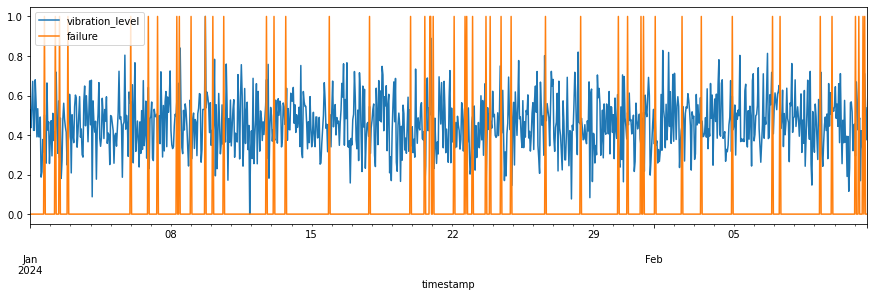

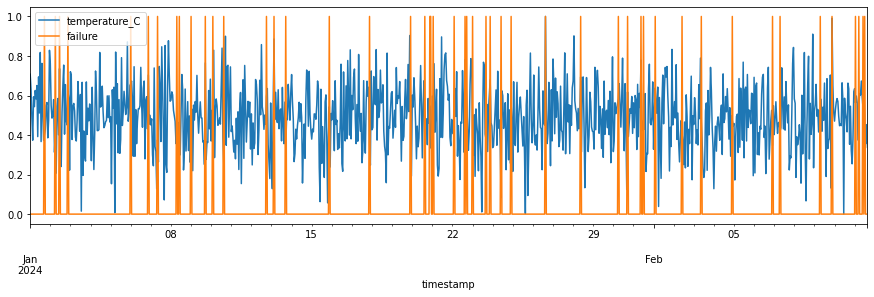

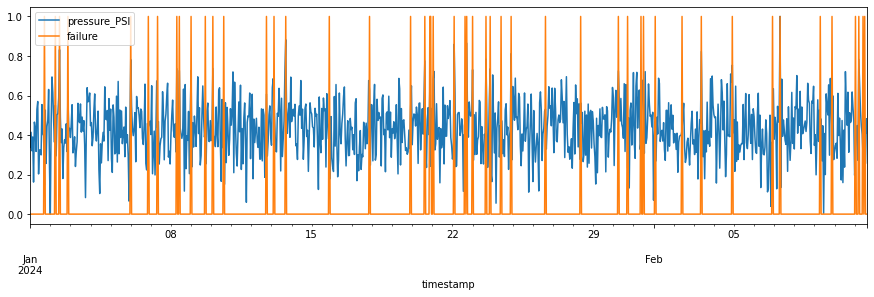

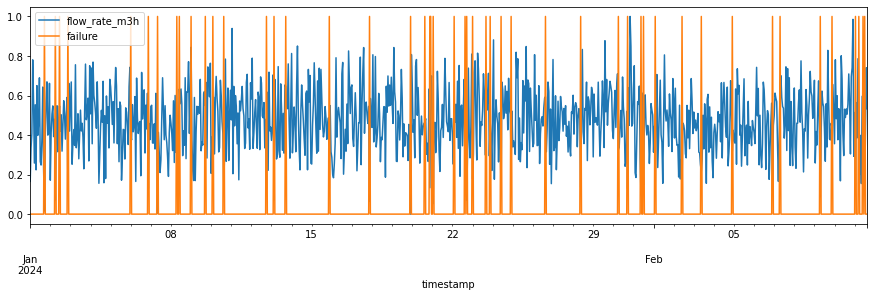

In [68]:
for FEATURE in FEATURES:
    df.plot(y=[FEATURE, 'failure'], kind='line', figsize =(15,4))

# Segmentation 

### To predict a target value at time t, use the previous n sample (SEQUENCE) features

Single-Feature Time Series Classification, Consider we have Temperature reading at various time point, as shown below.

Original Series: [T1, T2, T3, T4, T5, T6, T7, T8, T9, T10]

Segments:
- Segment 1: [T1, T2, T3, T4, T5]
- Segment 2: [T2, T3, T4, T5, T6]
- Segment 3: [T3, T4, T5, T6, T7]    

Multivariate Time Series classification:

Original Multivariate Series

    Time | Feature1 (Temp) | Feature2 (Pressure) | Feature3 (Flow)
    T1   | 30              | 100                 | 10
    T2   | 32              | 105                 | 11
    T3   | 31              | 100                 | 9
    T4   | 28              | 107                 | 10
    T5   | 29              | 102                 | 12
    ...
    T10  | 29              | 101                 | 12

Segments:
- Segment 1: 
  - Time Points: [T1, T2, T3]
  - Features: [[30, 100, 10], [32, 105, 11], [31, 98, 10]]
- Segment 2: 
  - Time Points: [T2, T3, T4]
  - Features: [[32, 105, 11], [31, 98, 10], [28, 107, 10]]

In [69]:
# pd.DataFrame([[f'X1_t{i}', f'X2_t{i}', f'X3_t{i}', f'Y_t{i}'] for i in range(20)], columns=['F1','F2','F3','Target'])

In [70]:
def preprocess_data(df):
    """Preprocess data to create sequences for model input.
    
    Args:
        df: The input DataFrame containing features with ou without target.

    Returns:
        np.array: Arrays of input sequences and corresponding target values.
    """
    X = df[FEATURES]
    if TARGET in df.columns:
        Y = df[TARGET]

    X_local, Y_local = [], []
    for start in range(0, len(df) - SEQUENCE_LENGTH, STEP):
        end = start + SEQUENCE_LENGTH
        X_local.append(X[start:end].values)
        if TARGET in df.columns:
            Y_local.append(Y.iloc[end])
    
    if TARGET in df.columns:
        return np.array(X_local), np.array(Y_local)
    else:
        return np.array(X_local), None

In [71]:
X_local, Y_local = preprocess_data(df)

In [72]:
X_local.shape, Y_local.shape

((990, 10, 4), (990,))

In [73]:
# import random
# random.randint(0, 1)

In [74]:
# X = data[cols_to_be_norm]
# Y = data['failure']

# sequence_length = 10
# step = 1

# X_local = list()
# Y_local = list()

# for start in range(0, len(data) - sequence_length, step):
#     end = start + sequence_length
#     X_local.append(X[start:end])
#     Y_local.append(Y[end-1])

# X_local = np.array(X_local)
# Y_local = np.array(Y_local)

# X_local.shape, Y_local.shape

## Class weight for Imbalanced Dataset

In [75]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y_local), y = Y_local)
class_weights = dict(zip(np.unique(Y_local), class_weights))
class_weights

{0: 0.5260361317747078, 1: 10.10204081632653}

In [76]:
model = keras.Sequential()
model.add(LSTM(100, input_shape = (10, 4)))
# model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.Precision(), keras.metrics.Recall()]
              , optimizer="adam")

model.summary()

D:\anaconda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,101 (164.46 KB)

 Trainable params: 42,101 (164.46 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
training_size = int(len(X_local) * 0.8)

X_train, y_train = X_local[:training_size], Y_local[:training_size]
X_test, y_test = X_local[training_size:], Y_local[training_size:]

X_train.shape, y_train.shape,X_test.shape, y_test.shape

((792, 10, 4), (792,), (198, 10, 4), (198,))

In [78]:
# X_train, y_train,X_test, y_test = train_test_split(X_local,Y_local, test_size=0.2)
# X_train.shape, y_train.shape,X_test.shape, y_test.shape

In [83]:
model.fit(X_train, y_train, batch_size=32, epochs=50, class_weight=class_weights)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6780 - precision: 0.0678 - recall: 0.4559 
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6656 - precision: 0.0788 - recall: 0.7145 
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 - precision: 0.0681 - recall: 0.5826         
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6203 - precision: 0.0509 - recall: 0.4440         
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6776 - precision: 0.0900 - recall: 0.8596 
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6236 - precision: 0.0937 - recall: 0.6584 
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6836 - precision: 0.0663 - recall: 0.5257         
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6480 - precision: 0.0931 - recall: 0.8417 
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6451 - precision: 0.0798 - recall: 0.6397 
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

In [87]:
y_test_pred = np.where(model.predict(X_test) > 0.8, 1, 0)
report = classification_report(y_test,y_test_pred)
print(report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       189
           1       0.25      0.22      0.24         9

    accuracy                           0.93       198
   macro avg       0.61      0.60      0.60       198
weighted avg       0.93      0.93      0.93       198



In [35]:
y_test_pred = np.where(model.predict(X_test) > 0.5, 1, 0)
report = classification_report(y_test,y_test_pred)
print(report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       188
           1       0.50      0.10      0.17        10

    accuracy                           0.95       198
   macro avg       0.73      0.55      0.57       198
weighted avg       0.93      0.95      0.93       198



In [36]:
from sklearn.metrics import confusion_matrix

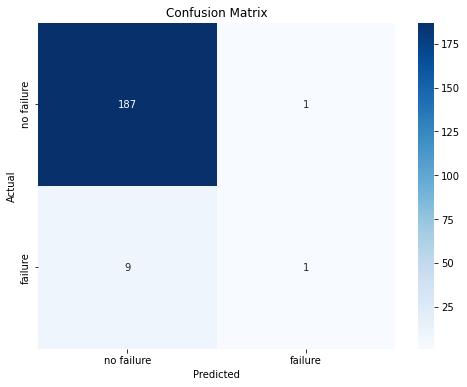

In [41]:
cm = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['no failure', 'failure'],
            yticklabels=['no failure', 'failure'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [27]:
model.save('my_model.h5')

## Improvement area 

    - Collect more datapoints
    - Existing model Hyper paramete tuning
    - Create multiple features from th temporal info
    - experiment with multiple models like XGBoost, MrSQM etc


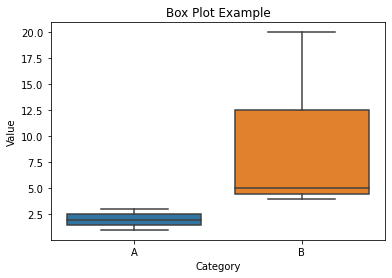

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = {
    'Category': ['A', 'A', 'A', 'B', 'B', 'B'],
    'Value': [1, 2, 3, 4, 5, 20]  # Note the outlier (20)
}

# Create a DataFrame
import pandas as pd
df = pd.DataFrame(data)

# Create a box plot
sns.boxplot(x='Category', y='Value', data=df)
plt.title('Box Plot Example')
plt.show()
